In [326]:
#!/usr/bin/env python

import sys
import os 
import math
import glob
import itertools

import numpy 
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors as rdm
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [327]:
# Load Data

df = pd.read_excel('MR1_map4-clean.xlsx') # xlsx is not ideal , is easier to convert here than in Excel

# Save the DataFrame to CSV format with comma as the delimiter
df.to_csv('MR1_map4-clean.csv', index=False)  # Set index=False to exclude row numbers in the CSV

df = pd.read_csv('MR1_map4-clean.csv')

df.head()

,Smiles,Name,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,Nc1ncnc2c1ncn2C1OC2COP(=O)(O)OC2C1O,HMDB0000058,20475335,6229689,15006086,6142749,4962372,715603,13145804,7676988,...,15453227,8015996,12878117,8773756,956826,2189840,214461,9329146,13674023,7097898
1,CC12CCC3c4cc(O)c(O)cc4CCC3C1CCC2=O,HMDB0000343,4910671,54181810,59057362,3642487,3209064,24834205,4198309,17531596,...,14233087,29347957,45482742,2290717,474142,3141410,4241570,1381180,10230455,289980
2,CC12CCC3c4ccc(O)cc4CCC3C1CC(=O)C2=O,HMDB0000372,44803545,42104668,28945995,3642487,3209064,24834205,4198309,17531596,...,3915001,131474,45482742,8476726,474142,3141410,4241570,1381180,36304919,17472174
3,CC12CCC3c4ccc(O)cc4CCC3C1CC(=O)C2O,HMDB0000406,44803545,54181810,28945995,2425114,3209064,24834205,4579409,17531596,...,3277631,29347957,45482742,7445941,474142,3141410,4241570,1381180,9292615,15468312
4,CC(=O)C1(O)CCC2C3CC=C4CC(OS(=O)(=O)[O-])CCC4(C...,HMDB0000416,6572000,7280350,1207484,8171915,11900044,11132591,284794,712580,...,19407403,23420021,338428,1810812,13399322,3141410,2867009,9163175,289191,142634


In [328]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
count,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,...,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03,3.993000e+03
mean,1.706323e+07,1.563797e+07,1.601029e+07,1.755895e+07,1.641917e+07,1.439605e+07,1.478867e+07,1.613854e+07,1.270398e+07,1.446015e+07,...,1.553309e+07,8.913317e+06,1.383790e+07,1.428615e+07,1.537130e+07,1.607836e+07,1.553972e+07,1.831980e+07,1.663728e+07,1.821670e+07
std,1.874867e+07,2.350734e+07,2.087626e+07,2.627144e+07,2.306640e+07,1.805250e+07,2.283439e+07,1.944628e+07,1.742301e+07,2.177578e+07,...,2.384406e+07,1.604735e+07,1.429898e+07,1.801472e+07,2.061748e+07,2.184676e+07,2.282582e+07,2.283340e+07,2.265867e+07,2.727748e+07
min,6.100000e+02,7.133000e+03,2.881500e+04,7.001000e+03,2.762000e+03,3.055100e+04,3.481400e+04,2.748000e+03,1.249900e+04,5.290000e+03,...,1.375000e+03,2.253000e+03,9.086000e+03,8.969000e+03,5.906000e+03,1.479600e+04,1.145100e+04,7.666000e+03,1.891900e+04,2.357400e+04
25%,4.257960e+06,2.349897e+06,3.947577e+06,2.943807e+06,3.499756e+06,3.812950e+06,3.041745e+06,3.326308e+06,1.788243e+06,4.061714e+06,...,3.227619e+06,1.150004e+06,3.943627e+06,3.577782e+06,3.314618e+06,3.141410e+06,2.810730e+06,4.628383e+06,3.617335e+06,3.805914e+06
50%,9.916928e+06,6.579972e+06,8.033062e+06,9.391761e+06,8.735147e+06,1.025371e+07,8.142905e+06,9.112100e+06,6.445923e+06,7.193354e+06,...,7.878271e+06,1.520701e+06,7.224044e+06,8.311411e+06,8.088956e+06,9.238496e+06,9.046249e+06,1.177307e+07,1.047823e+07,1.018052e+07
75%,2.360514e+07,1.827499e+07,1.723085e+07,2.185870e+07,1.992351e+07,1.632291e+07,1.593749e+07,1.997740e+07,1.557145e+07,1.362911e+07,...,1.700734e+07,1.216912e+07,1.978381e+07,2.052750e+07,1.906577e+07,2.025567e+07,1.898940e+07,2.354277e+07,2.105330e+07,2.185852e+07
max,1.624674e+08,2.717481e+08,1.572730e+08,3.444631e+08,2.698050e+08,1.832376e+08,4.354479e+08,1.873558e+08,2.188050e+08,3.280478e+08,...,3.537310e+08,3.286054e+08,1.023058e+08,2.572179e+08,3.933830e+08,2.489540e+08,4.023544e+08,4.519532e+08,2.893043e+08,4.387319e+08


Shorter version. Only <100 mol. Easier to compute. We will use full dataset later. 

For the fingerprints: Min value is 3.711060e+05 and Max value is 1.503716e+08. 
So 3 orders of magnitude... 


Data Frame (df) has Smiles code, name for each metabolite and 1024 columns with values ranging from 5 to 8 digits. This 1024 combination is the fingerprint that later we'll use for K-means clustering.

In [329]:
df.shape

(3993, 1026)

### Standardize or not to standardize, that is the question

Typically, data is standardized before performing a PCA. 
However, in the case of map4 fingerprints, I find that standarization might not be necessary due to being messured in the same scale (despite variations spanning three orders of magnitud). 
One would use standarization when contrasting disparate units like the height of a tree and the girth of the same tree. 

Altough HMDB database contains diverse lipids, phospholipids... which could explain the difference in magnitud for some fingerprints? So maybe standarization is due?

Let's try doing it and see what happens...

When it comes to using PCA, data standarization is usually the go-to step. However, the situation is a bit different with map4 fingerprints. Despite having variations that span three orders of magnitude (1e05 / 1e08) these fingerprints are actually measured on a consistent scale (map4). This makes me wonder if standarization is really necessary...
Statistics is not my area of expertise so i could be wrong!

We're comparing apples to apples so to speak... For instance, you'd standardize when comparing something like the height of a tree and the tree's girth – they're completely different units.

However... the HMDB database contains all sorts of stuff, lipids, phospholipids... This variety might be the reason behind the magnitude differences we're seeing in some fingerprints. Could standarization help with that??

We'll give standarization a shot and see if it changes things. Maybe it'll clear things up, maybe not. Either way, we'll get a better sense of whether standarization plays a role or not


In [330]:
# Select only the fingerprint bits columns for clustering

map4_fp = df.iloc[:, 2:].values # np array with shape (98, 1024) 98 molecules x 1024 fp / molecule

map4_fp.shape

(3993, 1024)

In [331]:
# Apply PCA to reduce dimensionality to 2 components

# Standardization (Z-score scaling)
std_scaler = StandardScaler()
data_std = std_scaler.fit_transform(map4_fp)

# Perform PCA on the standardized data
pca = PCA(n_components=2)
pca_std = pca.fit_transform(data_std) # Coordinates for std data

# Perform PCA on normal data 

pca_not_std = pca.fit_transform(map4_fp) # Coordinates for not std data

In [332]:
df['PCA_1-not_std'] = pca_not_std[:, 0]
df['PCA_2-not_std'] = pca_not_std[:, 1]
df['PCA_1-std'] = pca_std[:, 0]
df['PCA_2-std'] = pca_std[:, 1]

columns = ['Name', 'PCA_1-not_std', 'PCA_2-not_std', 'PCA_1-std', 'PCA_2-std']
results_df = df[columns]
results_df

,Name,PCA_1-not_std,PCA_2-not_std,PCA_1-std,PCA_2-std
0,HMDB0000058,-1.642645e+08,1.674656e+07,-7.389605,0.973675
1,HMDB0000343,-9.028430e+07,-8.150691e+06,-4.086619,-0.632689
2,HMDB0000372,-5.728615e+07,-2.275861e+07,-2.675883,-1.078877
3,HMDB0000406,-1.190716e+08,-2.164606e+07,-5.258263,-1.393546
4,HMDB0000416,-2.537843e+08,1.919883e+07,-11.904453,1.346031
...,...,...,...,...,...
3988,HMDB0303039,1.153458e+07,2.417039e+07,0.549148,0.368843
3989,HMDB0303072,-2.509015e+08,1.724049e+07,-11.586936,1.183068
3990,HMDB0303074,1.932340e+08,-7.317845e+06,8.799050,0.631842
3991,HMDB0303085,-3.141148e+08,8.464427e+06,-14.528472,1.147934


In [333]:
# Apply k-means clustering
num_clusters = 14 # Best K = 6
kmeans = KMeans(n_init = 500, n_clusters=num_clusters, random_state = 42)


In [334]:
label_not_std = kmeans.fit_predict(pca_not_std) 
# label (cluster assigned) for each molecule giving the coordinates (PCA_1 and PCA_2)
# Compute cluster centers and predict cluster index for each sample.

results_df['cluster-not_std'] = label_not_std
centroids_not_std = kmeans.cluster_centers_

label_not_std # Cluster predicted for each sample for not std data

/var/folders/3b/qc0964915w138dp3bgv_7rp80000gs/T/ipykernel_46885/56642012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['cluster-not_std'] = label_not_std


array([ 0, 10, 10, ...,  1, 13, 10], dtype=int32)

In [335]:
label_std = kmeans.fit_predict(pca_std) 
# label (cluster assigned) for each molecule giving the coordinates (PCA_1 and PCA_2)
# Compute cluster centers and predict cluster index for each sample.

results_df['cluster-std'] = label_std
centroids_std = kmeans.cluster_centers_

label_std # Cluster predicted for each sample for std data

/var/folders/3b/qc0964915w138dp3bgv_7rp80000gs/T/ipykernel_46885/4019008276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['cluster-std'] = label_std


array([ 0, 13, 13, ..., 11,  5, 13], dtype=int32)

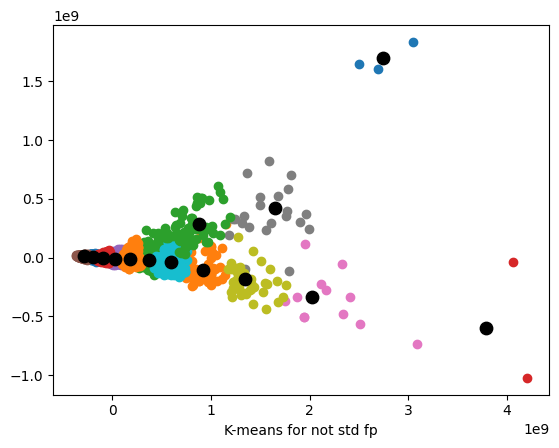

ValueError: x and y must be the same size

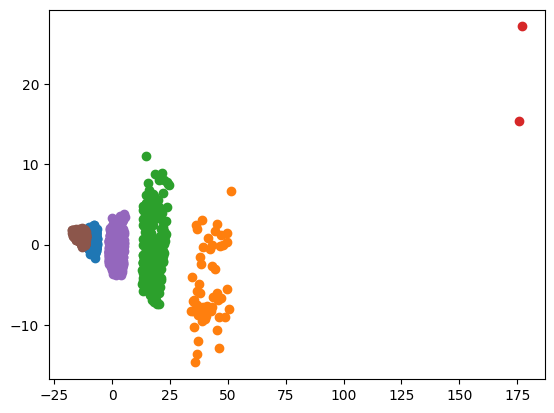

In [354]:
plt.scatter(cluster_0.iloc[:,1], cluster_0.iloc[:,2])

plt.scatter(cluster_1.iloc[:,1], cluster_1.iloc[:,2])
  
plt.scatter(cluster_2.iloc[:,1], cluster_2.iloc[:,2])
  
plt.scatter(cluster_3.iloc[:,1], cluster_3.iloc[:,2])
  
plt.scatter(cluster_4.iloc[:,1], cluster_4.iloc[:,2])
 
plt.scatter(cluster_5.iloc[:,1], cluster_5.iloc[:,2])
  
plt.scatter(cluster_6.iloc[:,1], cluster_6.iloc[:,2])
  
plt.scatter(cluster_7.iloc[:,1], cluster_7.iloc[:,2])

plt.scatter(cluster_8.iloc[:,1], cluster_8.iloc[:,2])
  
plt.scatter(cluster_9.iloc[:,1], cluster_9.iloc[:,2])
  
plt.scatter(cluster_10.iloc[:,1], cluster_10.iloc[:,2])

plt.scatter(cluster_11.iloc[:,1], cluster_11.iloc[:,2])
  
plt.scatter(cluster_12.iloc[:,1], cluster_12.iloc[:,2])
  
plt.scatter(cluster_13.iloc[:,1], cluster_13.iloc[:,2])

plt.scatter(cluster_14.iloc[:,1], cluster_14.iloc[:,2])
  

plt.scatter(centroids_not_std[:,0] , centroids_not_std[:,1] , s = 80, color = 'k')
plt.xlabel('K-means for not std fp')
plt.show()
  


plt.scatter(cluster_0.iloc[:,3], cluster_0.iloc[:,4])

plt.scatter(cluster_1.iloc[:,3], cluster_1.iloc[:,4])
  
plt.scatter(cluster_2.iloc[:,3], cluster_2.iloc[:,4])
  
plt.scatter(cluster_3.iloc[:,3], cluster_3.iloc[:,4])
  
plt.scatter(cluster_4.iloc[:,3], cluster_4.iloc[:,4])
  
plt .scatter(cluster_5.iloc[:,3], cluster_5.iloc[:,4])

plt.scatter(cluster_7.iloc[:,3], cluster_6.iloc[:,4])

plt.scatter(cluster_8.iloc[:,3], cluster_7.iloc[:,4])
  
plt.scatter(cluster_9.iloc[:,3], cluster_8.iloc[:,4])
  
plt.scatter(cluster_10.iloc[:,3], cluster_9.iloc[:,4])
  
plt.scatter(cluster_11.iloc[:,3], cluster_10.iloc[:,4])
  
plt .scatter(cluster_12.iloc[:,3], cluster_11.iloc[:,4])

plt.scatter(cluster_13.iloc[:,3], cluster_12.iloc[:,4])
  
plt.scatter(cluster_14.iloc[:,3], cluster_13.iloc[:,4])

plt.scatter(cluster_14.iloc[:,3], cluster_14.iloc[:,4])




plt.scatter(centroids_std[:,0] , centroids_std[:,1] , s = 80, color = 'k')

# Combine all the operations and display
plt.xlabel('K-means for std fp')
plt.show()

In [341]:
cluster_0 = results_df[results_df['cluster-std']==0]
cluster_1 = results_df[results_df['cluster-std']==1]
cluster_2 = results_df[results_df['cluster-std']==2]
cluster_3 = results_df[results_df['cluster-std']==3]
cluster_4 = results_df[results_df['cluster-std']==4]
cluster_5 = results_df[results_df['cluster-std']==5]
cluster_6 = results_df[results_df['cluster-std']==6]
cluster_7 = results_df[results_df['cluster-std']==7]
cluster_8 = results_df[results_df['cluster-std']==8]
cluster_9 = results_df[results_df['cluster-std']==9]
cluster_10 = results_df[results_df['cluster-std']==10]
cluster_11 = results_df[results_df['cluster-std']==11]
cluster_12 = results_df[results_df['cluster-std']==12]
cluster_13 = results_df[results_df['cluster-std']==13]
cluster_14 = results_df[results_df['cluster-std']==14]

cluster_0

,Name,PCA_1-not_std,PCA_2-not_std,PCA_1-std,PCA_2-std,cluster-not_std,cluster-std
0,HMDB0000058,-1.642645e+08,1.674656e+07,-7.389605,0.973675,0,0
21,HMDB0001000,-2.092862e+08,-2.633156e+06,-9.492909,0.192725,0,0
23,HMDB0001091,-2.420351e+08,1.579235e+07,-11.274949,1.151537,0,0
24,HMDB0001204,-2.419828e+08,5.120782e+06,-11.290312,0.393500,0,0
25,HMDB0001244,-1.926155e+08,6.227512e+06,-8.921267,0.318771,0,0
...,...,...,...,...,...,...,...
3977,HMDB0302864,-1.481412e+08,1.106636e+07,-6.783968,0.277512,0,0
3980,HMDB0302972,-1.565352e+08,4.117497e+06,-7.102878,0.517241,0,0
3982,HMDB0302987,-1.798655e+08,-6.359999e+06,-8.194632,-0.133181,0,0
3984,HMDB0303024,-1.813236e+08,2.489214e+07,-8.352484,1.139229,0,0


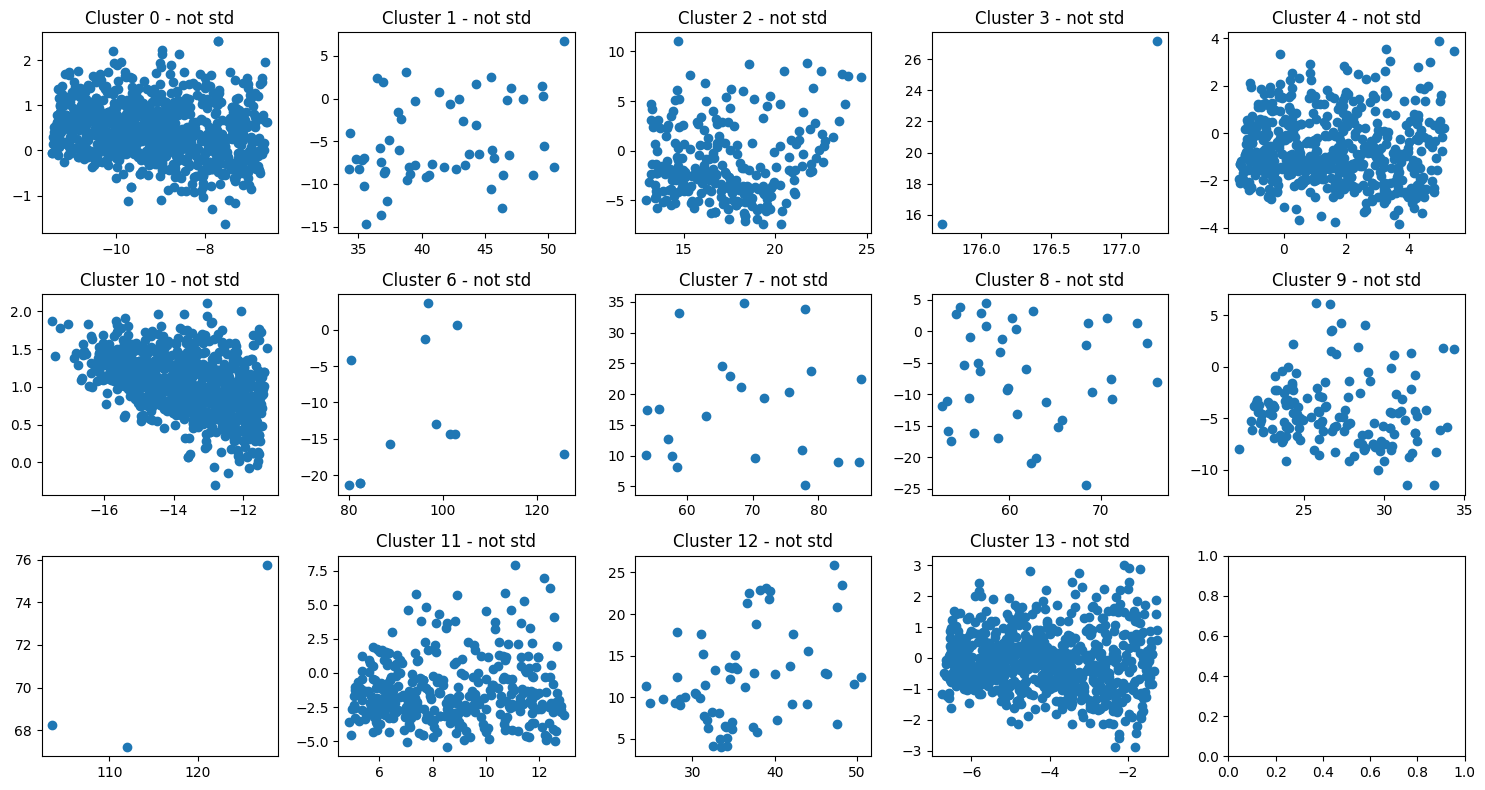

In [353]:
# Assuming you have 7 DataFrames named df1, df2, ..., df7
# Each DataFrame has 'X' and 'Y' columns

data_frames = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5]
titles = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']

# Create a 2x4 grid layout for 6 subplots
num_rows = 3
num_cols = 5
fig, axis = plt.subplots(num_rows, num_cols, figsize=(15, 8))



axis[0, 0].scatter(cluster_0.iloc[:,3], cluster_0.iloc[:,4])
axis[0, 0].set_title("Cluster 0 - not std")
  
axis[0, 1].scatter(cluster_1.iloc[:,3], cluster_1.iloc[:,4])
axis[0, 1].set_title("Cluster 1 - not std")
  
axis[0, 2].scatter(cluster_2.iloc[:,3], cluster_2.iloc[:,4])
axis[0, 2].set_title("Cluster 2 - not std")
  
axis[0, 3].scatter(cluster_3.iloc[:,3], cluster_3.iloc[:,4])
axis[0, 3].set_title("Cluster 3 - not std")
  
axis[0, 4].scatter(cluster_4.iloc[:,3], cluster_4.iloc[:,4])
axis[0, 4].set_title("Cluster 4 - not std")
  
axis[1, 0].scatter(cluster_5.iloc[:,3], cluster_5.iloc[:,4])
axis[1, 0].set_title("Cluster 5 - not std")
  
axis[1, 1].scatter(cluster_6.iloc[:,3], cluster_6.iloc[:,4])
axis[1, 1].set_title("Cluster 6 - not std")
  
axis[1, 2].scatter(cluster_7.iloc[:,3], cluster_7.iloc[:,4])
axis[1, 2].set_title("Cluster 7 - not std")
  
axis[1, 3].scatter(cluster_8.iloc[:,3], cluster_8.iloc[:,4])
axis[1, 3].set_title("Cluster 8 - not std")
  
axis[1, 4].scatter(cluster_9.iloc[:,3], cluster_9.iloc[:,4])
axis[1, 4].set_title("Cluster 9 - not std")

axis[2, 0].scatter(cluster_10.iloc[:,3], cluster_10.iloc[:,4])
axis[1, 0].set_title("Cluster 10 - not std")
  
axis[2, 1].scatter(cluster_11.iloc[:,3], cluster_11.iloc[:,4])
axis[2, 1].set_title("Cluster 11 - not std")
  
axis[2, 2].scatter(cluster_12.iloc[:,3], cluster_12.iloc[:,4])
axis[2, 2].set_title("Cluster 12 - not std")
  
axis[2, 3].scatter(cluster_13.iloc[:,3], cluster_13.iloc[:,4])
axis[2, 3].set_title("Cluster 13 - not std")

# Combine all the operations and display
plt.tight_layout()
plt.show()

In [352]:
results_df

,Name,PCA_1-not_std,PCA_2-not_std,PCA_1-std,PCA_2-std,cluster-not_std,cluster-std
0,HMDB0000058,-1.642645e+08,1.674656e+07,-7.389605,0.973675,0,0
1,HMDB0000343,-9.028430e+07,-8.150691e+06,-4.086619,-0.632689,10,13
2,HMDB0000372,-5.728615e+07,-2.275861e+07,-2.675883,-1.078877,10,13
3,HMDB0000406,-1.190716e+08,-2.164606e+07,-5.258263,-1.393546,10,13
4,HMDB0000416,-2.537843e+08,1.919883e+07,-11.904453,1.346031,13,5
...,...,...,...,...,...,...,...
3988,HMDB0303039,1.153458e+07,2.417039e+07,0.549148,0.368843,4,4
3989,HMDB0303072,-2.509015e+08,1.724049e+07,-11.586936,1.183068,13,5
3990,HMDB0303074,1.932340e+08,-7.317845e+06,8.799050,0.631842,1,11
3991,HMDB0303085,-3.141148e+08,8.464427e+06,-14.528472,1.147934,13,5


In [351]:
results_df[['Name', 'cluster-not_std', 'cluster-std']].to_csv('results_df.csv',index=False)